In [1]:
import sys
import os
import shutil

_module_path = os.path.abspath("../../")
print(_module_path)
sys.path.append(_module_path)

import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calibration_libs.ccalibration import CCameraCalibration
from calibration_libs.utils import get_chess_corners, get_chess_corners_world, img_to_world_by_dis, world_to_img_l, vis_disparity, toOpen3dCloud, depth2xyzmap
import imageio
import open3d as o3d

c:\Users\86994\Desktop\camera_kit
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
images_path =  os.path.abspath('../calibration/images_640x480')
# 标定板参数
chessSize=[11, 8] # col, row, 长边设置为col, 短边row , col作为x轴， row作为y轴
chessCellLen=20 # 单位 mm
#相机标定类
mycc = CCameraCalibration()  #初始化
mycc.set_calibration_images(images_path, 15, 480, 1280, size=chessSize, length=chessCellLen) #设置标定图像的路径和图片数量
mycc.stereo_calibration(True, reversal=False) #进行双目立体标定，得到内参矩阵、畸变系数、重映射矩阵map、重投影矩阵Q等
mycc.print_p()

['WIN_20251207_14_54_12_Pro.jpg', 'WIN_20251207_14_54_42_Pro.jpg', 'WIN_20251207_14_54_48_Pro.jpg', 'WIN_20251207_14_54_55_Pro.jpg', 'WIN_20251207_14_55_08_Pro.jpg', 'WIN_20251207_14_55_13_Pro.jpg', 'WIN_20251207_14_55_20_Pro.jpg', 'WIN_20251207_14_55_26_Pro.jpg', 'WIN_20251207_14_55_45_Pro.jpg', 'WIN_20251207_14_55_53_Pro.jpg', 'WIN_20251207_14_56_02_Pro.jpg', 'WIN_20251207_14_56_07_Pro.jpg', 'WIN_20251207_14_56_32_Pro.jpg', 'WIN_20251207_14_56_40_Pro.jpg', 'WIN_20251207_14_56_44_Pro.jpg', 'WIN_20251207_14_56_48_Pro.jpg', 'WIN_20251207_14_57_01_Pro.jpg', 'WIN_20251207_14_57_06_Pro.jpg', 'WIN_20251207_14_57_11_Pro.jpg', 'WIN_20251207_14_57_16_Pro.jpg']
you have calibrated !
左图对应相机的内参..................................
[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]

右图对应相机的内参..................................
[[338.19616913   0.         279.11848074]
 [  0.         338.04469341 231.75555723]
 [  0.           

In [4]:
# 加载模型
model_path = r"C:\Users\86994\Desktop\pretrained_models\foundation_stereo_small.onnx"

so = ort.SessionOptions()

# ===== 常用可调参数 =====
# 1) 图优化等级（最常调）
so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL # ORT_ENABLE_EXTENDED（常用） # ORT_ENABLE_ALL（最激进）

# 2) 线程控制
so.intra_op_num_threads = 8   # CPU 内部算子并行
so.inter_op_num_threads = 8   # 多算子并行

# 4) 启用 profiling（做性能分析时用）
so.enable_profiling = False   # True 打开，会生成 profile 文件

# 6) 设置执行模式（默认 parallel）
so.execution_mode = ort.ExecutionMode.ORT_PARALLEL
# 另一种:
# ort.ExecutionMode.ORT_SEQUENTIAL

# =======================================
# 创建 Session
sess = ort.InferenceSession(
    model_path,
    sess_options=so,
    providers=["CPUExecutionProvider"]
)


In [5]:

# ====== 完全等效于 torchvision.transforms.Normalize ======
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 3, 1, 1)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 3, 1, 1)

def preprocess_image(img, size=(640, 480)):
    """
    按你给的 normalize_image(img) 完全一致的方式预处理。
    输入: RGB 0-255
    Normalize: (img/255 - mean) / std
    最终 shape = (1,3,480,640)
    """
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

    img = img.astype(np.float32)
    img = np.transpose(img, (2, 0, 1))      # HWC → CHW
    img = np.expand_dims(img, axis=0)       # CHW → BCHW

    # --- 关键：完全复现 torchvision Normalize(mean,std) ---
    img = img / 255.0
    img = (img - MEAN) / STD                # 标准化
    # -----------------------------------------------------

    return img

In [ ]:
# XFORMERS_DISABLED=1 python make_onnx.py --save_path ./foundation_stereo_small.onnx --ckpt_dir ../../../pretrained_models/11-33-40/model_best_bp2.pth --height 480 --width 640 --valid_iters 32

图像形状: (480, 1280, 3)


Text(0.5, 1.0, 'Remap')

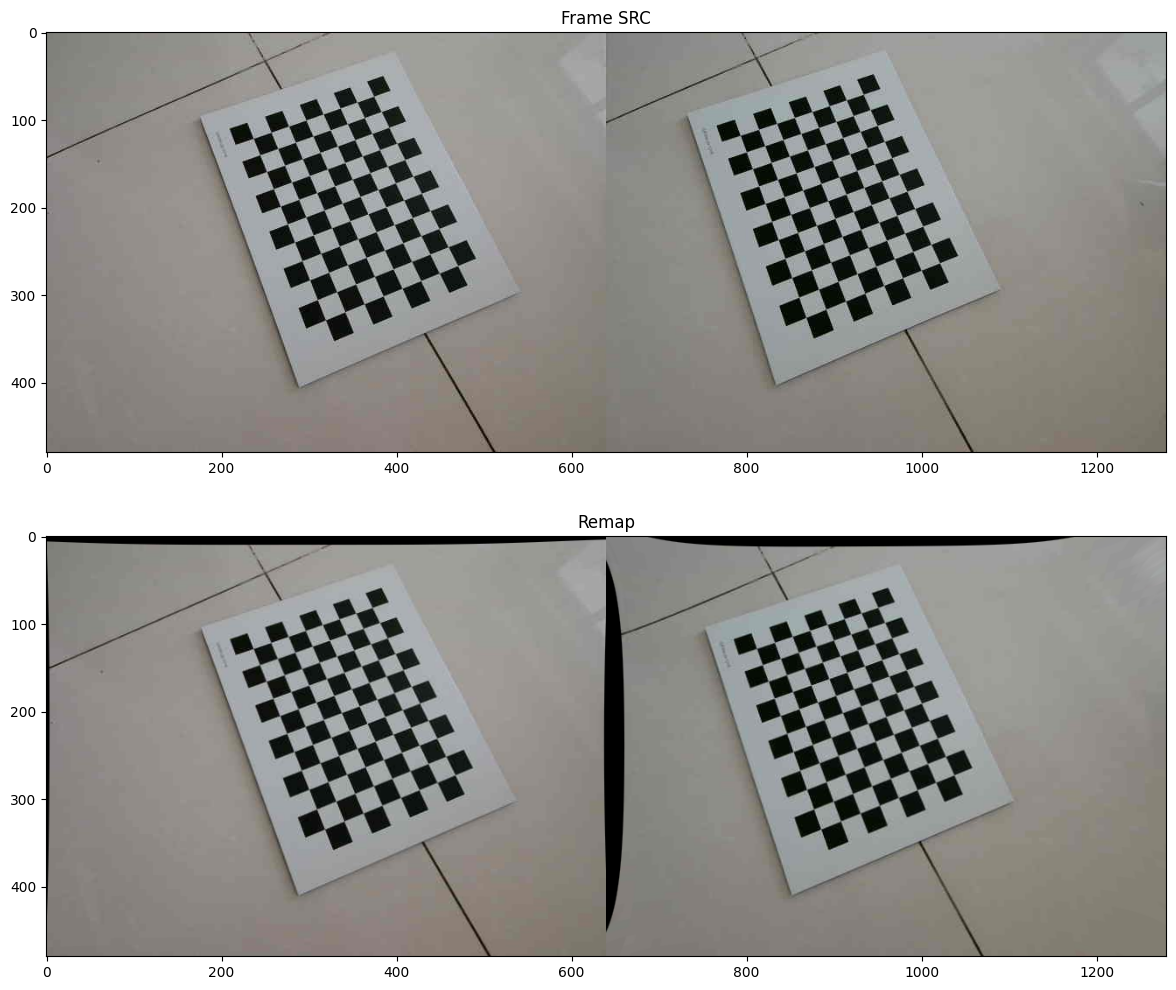

In [6]:

# 立体校正
img_path = '../calibration/images_640x480/WIN_20251207_14_54_12_Pro.jpg'
# img_path = r"C:\Users\86994\Pictures\Camera Roll\WIN_20251212_22_25_10_Pro.jpg"

img_src = cv2.imread(img_path)
print("图像形状:", img_src.shape)
_height, _width, _c = img_src.shape
left_src = img_src[:, 0: _width//2] #拆分左右图像
right_src = img_src[:, _width//2:]

#立体校正
left_remap = cv2.remap(left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
right_remap = cv2.remap(right_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
img_remap =  cv2.hconcat([left_remap, right_remap]) #合并校正后图像

left_remap_orig = cv2.cvtColor(left_remap, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Frame SRC")   # 左图标题

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")   # 左图标题

In [7]:
left_input = preprocess_image(left_remap)
right_input = preprocess_image(right_remap)

In [8]:
inputs = {
    "left": left_input,
    "right": right_input
}

disp_ort_out = sess.run(["disp"], inputs)[0]  # shape: [1,1,480,640]
print("推理完成：")
print("disp_ort_out shape =", disp_ort_out.shape)
print("disp_ort_out min =", disp_ort_out.min(), "max =", disp_ort_out.max())

推理完成：
disp_ort_out shape = (1, 1, 480, 640)
disp_ort_out min = 57.126316 max = 78.95543


In [9]:
disp = disp_ort_out[0,0]

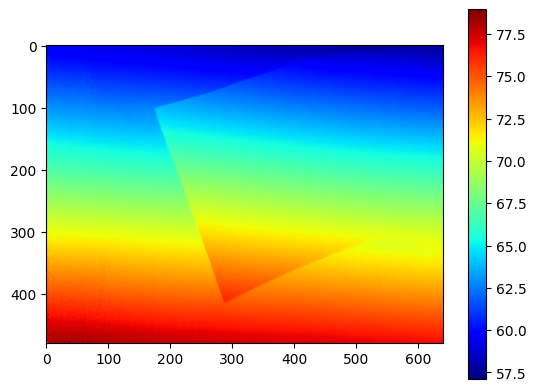

In [10]:
plt.imshow(disp, cmap='jet')
plt.colorbar()
plt.show()

In [11]:
out_dir = f'./test_outputs/'

In [12]:
np.save(os.path.join(out_dir, 'disp.npy'), disp)
vis = vis_disparity(disp)
vis = np.concatenate([left_remap_orig, vis], axis=1)
imageio.imwrite(os.path.join(out_dir, 'vis.png'), vis)
print(f"Output saved to {out_dir}")

Output saved to ./test_outputs/


In [13]:
# --remove_invisible', default=1, type=int, help='remove non-overlapping observations between left and right images from point cloud, so the remaining points are more reliable')
remove_invisible = 1
disp_ri = disp.copy()
if remove_invisible:
    yy, xx = np.meshgrid(np.arange(disp_ri.shape[0]), np.arange(disp_ri.shape[1]), indexing='ij')
    us_right = xx-disp_ri
    invalid = us_right<0
    disp_ri[invalid] = np.inf

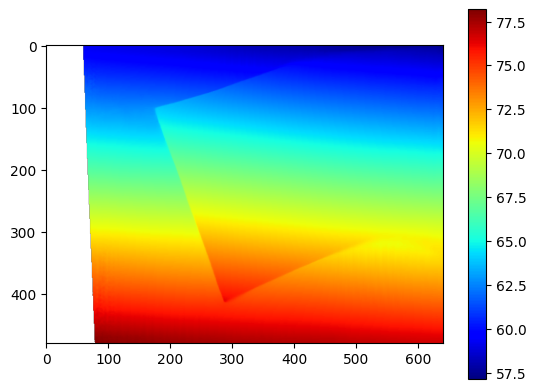

In [14]:
plt.imshow(disp_ri, cmap='jet')
plt.colorbar()
plt.show()

In [15]:
# ('--get_pc', type=int, default=1, help='save point cloud output')
get_pc = 1
K = mycc._leftParameters['cameraMatrix']
baseline = 0.06 # 单位 m
print(K)

[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]


In [16]:
depth = K[0,0]*baseline/disp # K[0][0] = f 焦距
np.save(f'{out_dir}/depth_meter.npy', depth)

In [17]:
xyz_map = depth2xyzmap(depth, K)
pcd = toOpen3dCloud(xyz_map.reshape(-1,3), left_remap_orig.reshape(-1,3))
z_far = 20
keep_mask = (np.asarray(pcd.points)[:,2]>0) & (np.asarray(pcd.points)[:,2]<=z_far)
keep_ids = np.arange(len(np.asarray(pcd.points)))[keep_mask]
pcd = pcd.select_by_index(keep_ids)
o3d.io.write_point_cloud(f'{out_dir}/cloud.ply', pcd)
print(f"PCL saved to {out_dir}")

PCL saved to ./test_outputs/


In [18]:
# denoise_nb_points', type=int, default=30, help='number of points to consider for radius outlier removal')
# denoise_cloud', type=int, default=1, help='whether to denoise the point cloud')
# denoise_radius', type=float, default=0.03, help='radius to use for outlier removal')

denoise_cloud = 1
denoise_nb_points = 5
denoise_radius = 0.05

if denoise_cloud:
    print("[Optional step] denoise point cloud...")
    cl, ind = pcd.remove_radius_outlier(nb_points=denoise_nb_points, radius=denoise_radius)
    inlier_cloud = pcd.select_by_index(ind)
    o3d.io.write_point_cloud(f'{out_dir}/cloud_denoise.ply', inlier_cloud)
    pcd = inlier_cloud

print("Visualizing point cloud. Press ESC to exit.")
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.get_render_option().point_size = 1.0
vis.get_render_option().background_color = np.array([0.5, 0.5, 0.5])
vis.run()
vis.destroy_window()


[Optional step] denoise point cloud...
Visualizing point cloud. Press ESC to exit.
